In [1]:
# Import public modules
import torch
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload

# Import custom modules
from src import managers
from src import utils
from src.models import discrete_models

In [11]:
## Define some utility functions
def plot_data_distr(x, title=None, ax=None, label_symbols_list=None, color='hotpink', bar_label=None):
    """ Plot the data distribution. """
    # Define some plot specs
    alpha_plot = 0.5

    # Define default label symbols list
    if label_symbols_list is None:
        # Define the label symbols
        label_symbols_1 = ['A:0', '<MASK>:0', 'B:0']
        label_symbols_2 = ['A:1', 'B:1', '<MASK>:1', 'C:1']
        label_symbols_list = [label_symbols_1, label_symbols_2]
    
    # Determine the discrete state pace dimension
    space_dim = x.shape[1]

    # Make the figure
    fig, axs = plt.subplots(1, space_dim, figsize=(4*space_dim, 4))

    # Set a supertile if the title is passed (i.e. not None)
    if title is not None:
        plt.suptitle(title)

    # Loop over the components of the discrete state space
    for d in range(space_dim):
        # Get axis corresponding to the current component 'd'
        ax = axs[d]

        # Get the label symbols
        label_symbols = label_symbols_list[d]

        # Determine and plot the distribution
        pos, counts = np.unique(x[:, d], return_counts=True)
        counts = counts/np.sum(counts) # Normalize the counts
        ax.bar(pos, counts, align='center', color=color, alpha=alpha_plot, label=bar_label)

        # Set plot specs
        ax.set_title(f"Component-{d}") # Title of subplot

        ax.set_xticks(list(range(len(label_symbols))))
        ax.set_xticklabels(label_symbols)
        ax.set_xlim([-0.5, len(label_symbols)-0.5])
        ax.set_ylim([0, 1])
        ax.set_yticks([])
        ax.set_xlabel(r'$x_'+str(d)+'$')
        if d==0:
            ax.set_ylabel('Density')

    plt.show()

[0 2 2 0 0 0 0 2 0 2]
[1 3 3 3 3 3 3 3 1 3]
(1000, 2)
[[0 1]
 [2 3]
 [2 3]
 [0 3]
 [0 3]
 [0 3]
 [0 3]
 [2 3]
 [0 1]
 [2 3]]
[ 3 11 11  9  9  9  9 11  3 11]


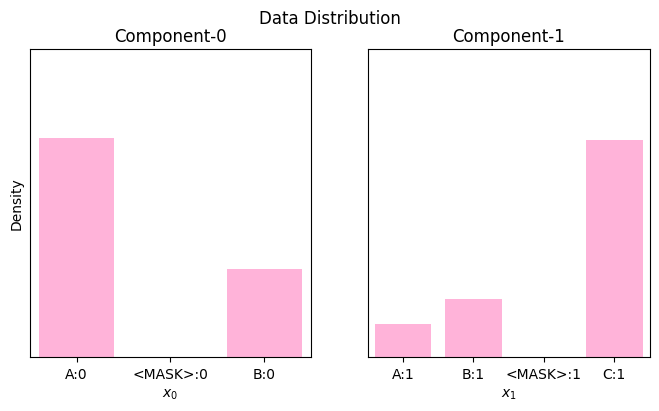

In [55]:
######################################
### Generate 2D-categorical data
######################################
# Define the number of datapoints
num_datapoints = 1000

# Define the label symbols
label_symbols_1 = ['A:0', '<MASK>:0', 'B:0']
label_symbols_2 = ['A:1', 'B:1', '<MASK>:1', 'C:1']
label_symbols_list = [label_symbols_1, label_symbols_2]

# Sample data into two classes (i.e. their labels) 'A' (index 0) and 'B' (index 2)
# while defining the probability to sample class 'A' (i.e. prob_B=1-prob_A)
np.random.seed(42)
# d=1
prob_A   = 0.7
x_data_1 = np.random.choice([0, 2], size=(num_datapoints,), p=[prob_A, 1-prob_A])
print(x_data_1[:10])
# d=2
prob_A   = 0.2
x_data_2 = np.random.choice([0, 1, 3], size=(num_datapoints,), p=[0.1, 0.2, 0.7])
print(x_data_2[:10])
# Stack the data
X_data = np.vstack([x_data_1, x_data_2]).T
print(X_data.shape)

# Generate the y-data by labeling all possible states
def get_label(x1, x2, num_x1_states):
    return x1 + x2*num_x1_states
y_data = get_label(X_data[:, 0], X_data[:, 1], 3)
print(X_data[:10])
print(y_data[:10])

# Plot the data distribution
plot_data_distr(X_data, title='Data Distribution', label_symbols_list=label_symbols_list)


Training the 'denoising' model for '100' epochs.
[0] 16627744.0


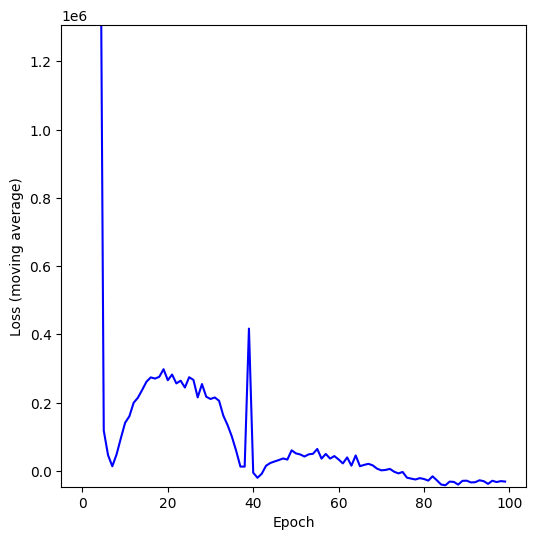

Last epoch loss (moving average): -30738.619140625

----------------------------------------------------------------------------------------------------

Training the 'property' model for '200' epochs.
[0] 2462.50439453125
[100] 594.9362182617188


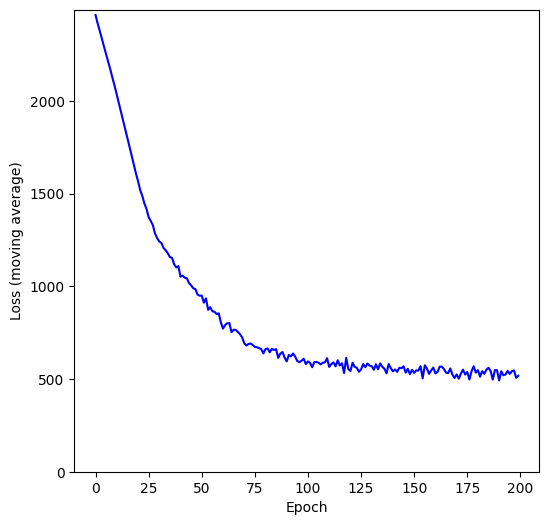

Last epoch loss (moving average): 517.4071655273438

Generation done


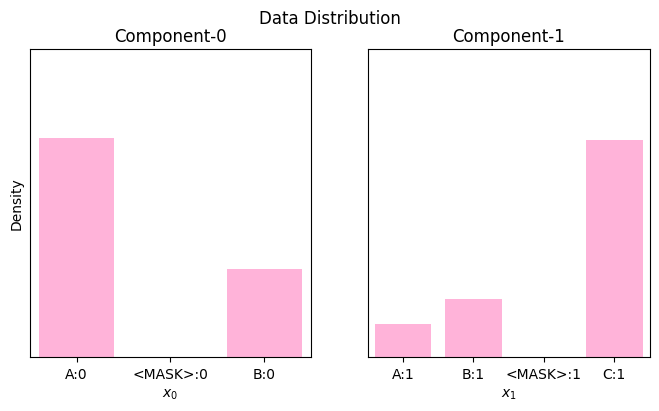

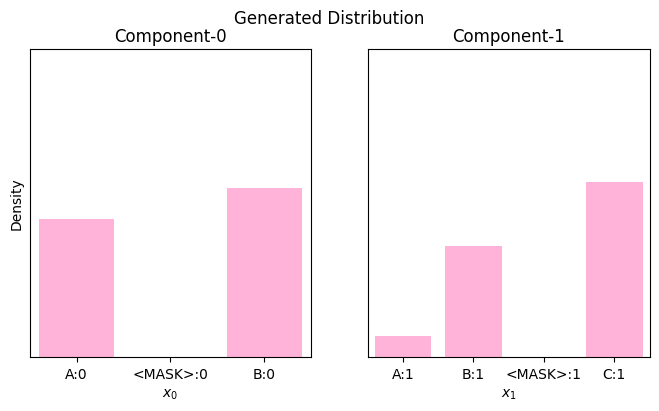

In [62]:
# Reload custom modules
reload(utils)
reload(managers)
reload(discrete_models)

# Use guided diffusion?
use_guided_diffusion = True

# Use an unconditional denoising model
torch.random.manual_seed(20)
denoising_model = discrete_models.DenoisingModel(x_enc_dim=7, t_dim=1, lat_dim=100)

# Define an optimizer for the model parameters of the denoising model
denoising_optimizer = torch.optim.Adam(denoising_model.parameters(), lr=0.01) #0.01

# Differ cases where we wanna use guided diffusion or not
if use_guided_diffusion:
    # Use guided diffusion
    # Initialize the property model if we want to use guided diffusion
    torch.random.manual_seed(21)
    property_model = discrete_models.PropertyModel(x_enc_dim=7, t_dim=1, y_dim=12, lat_dim=10)

    # Define an optimizer for the model parameters of the property model (used for guidance)
    property_optimizer  = torch.optim.Adam(property_model.parameters(), lr=0.01) #0.01

    # Define a diffusion manager object
    torch.random.manual_seed(72)
    diffusion_manager = managers.DiscreteDiffusionManager(denoising_model, denoising_optimizer, prob_vec_1_list=[[0, 1, 0], [0, 0, 1, 0]], gamma_scale=2, property_model=property_model, property_optimizer=property_optimizer) #2
else:
    # Do not use guided diffusion
    # Define a diffusion manager object
    torch.random.manual_seed(72)
    diffusion_manager = managers.DiscreteDiffusionManager(denoising_model, denoising_optimizer, prob_vec_1_list=[[0, 1, 0], [0, 0, 1, 0]], gamma_scale=2) #, debug=True) #2

# Q_t = diffusion_manager.Q(torch.tensor([0.1, 0.2, 0.3]).reshape(-1, 1))
# print(Q_t)
# print(Q_t.to_dense())
# raise ValueError("AM HERE")
#print(diffusion_manager._subspace_projector)

# # Forward sample z_t
# z_t = diffusion_manager.forward_sample_z_t(torch.tensor(X_data[:10], dtype=torch.int), 1)
# print(f"z_t.shape: {z_t.shape}")
# print(f"z_t[:10]:  {z_t[:10]}")


##########################################################################################################
### 4) Model training
##########################################################################################################
# Define the training dataset and a dataloader
train_dataset    = utils.DictDataset(x=torch.tensor(X_data, dtype=torch.int), y=torch.tensor(y_data, dtype=torch.int))
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=X_data.shape[0], shuffle=True)

# Train the denoising model
torch.random.manual_seed(43)
diffusion_manager.train(train_dataloader, which_model='denoising', num_epochs=100)
print()
print('-'*100)
print()

# Train the property model if we use guided diffusion
if use_guided_diffusion:
    diffusion_manager.train(train_dataloader, which_model='property', num_epochs=200)

# torch.manual_seed(42)
# print(diffusion_manager._sample_z_1(10))

# Generate novel points
#diffusion_manager._debug = True
x_generated = diffusion_manager.generate(batch_size=200, num_integration_points=100, random_seed=24, y=get_label(2, 1, 3), guide_temp=10)
print()
print("Generation done")

# Plot the data distribution
plot_data_distr(X_data, title='Data Distribution', label_symbols_list=label_symbols_list)

# Plot the generated distribution
plot_data_distr(x_generated, title='Generated Distribution', label_symbols_list=label_symbols_list)

In [ ]:
# Show the noise schedule
#diffusion_manager.show_noise_schedule()

# # Sample forward in time
# plot_data_distr(x_data, title='Data Distribution', label_symbols=label_symbols)

# torch.random.manual_seed(42)
# z_t = diffusion_manager.forward_sample_z_t(torch.tensor(x_data), 1)
# plot_data_distr(z_t, title='Data Distribution', label_symbols=label_symbols)

# Calculate the diffusion loss
# batch_data = {'x': torch.tensor(x_data[:2]).reshape(-1, 1)}
# torch.random.manual_seed(43)
# diffusion_manager.diffusion_batch_loss(batch_data)





# # Overplot the data and generated distributions
# plt.figure()
# ax = plt.gca()

# # Plot the data distribution
# plot_data_distr(x_data, ax=ax, label_symbols=label_symbols, color='tan', bar_label='data')

# # Plot the data distribution
# plot_data_distr(x_generated, ax=ax, label_symbols=label_symbols, color='hotpink', bar_label='generated')

# plt.legend()
# plt.show()

# # print()
# # print('-'*100)
# # print()
# x = torch.tensor([
#         [0, 0],
#         [1, 0],
#         [2, 0],
#         [0, 1],
#         [1, 1],
#         [2, 1],
#         [0, 2],
#         [1, 2],
#         [2, 2],
#         [0, 3],
#         [1, 3],
#         [2, 3],
#     ])

# x_encoded = diffusion_manager.encode_x(x)
# print(x_encoded.shape)
# print(x_encoded)
# x_decoded = diffusion_manager.decode_x(x_encoded)
# print(x_decoded.shape)
# print(x_decoded)

# # print(diffusion_manager.x_encoding_space_dim)
# # print(diffusion_manager.encoding_start_index)
# # x_d_encoded = torch.tensor([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
# # print(x_d_encoded.shape)
# # print(diffusion_manager.decode_x_d(x_d_encoded, 0))

# print(diffusion_manager.A_1.shape)
# print(diffusion_manager.A_1)
# print(diffusion_manager.Id.shape)
# print(diffusion_manager.Id)

In [ ]:
# Construct state_space manager
class DiscreteStateSpaceManager(object):
    def __init__(self, cardinality, dimension=None):
        """
        Args:
            cardinality (int or iterable of ints): Cardinality of each 1D component 
                (i.e. subspace) either as single integer (if it is the same for all 
                components) or as iterable holding strictly positive integers whose
                length corresponds to the dimension of the space.
            dimension (None or int): If not None, dimension of the discrete space 
                as strictly positive integer.
                (Default: None)

        Remark: If the dimension is specified/passed (i.e. not None) and the cardinality 
                is passed as iterable, the number of elements in the cardinality iterable
                must match the dimension.
                If the cardinality is passed as integer, the dimension must be specified
                (i.e. it cannot be None).
            
        """
        # Determine the cardinalities
        self.cardinalities = self._determine_cardinalities(cardinality, dimension)
        
    def _determine_cardinalities(self, cardinality, dimension):
        """
        Determine the cardinalities of each discrete subspace based on the cardinality and 
        dimension passed as inputs to the class-constructor (i.e. the '__init__' method).
        """
        # Parse inputs
        if isinstance(cardinality, (list, tuple)):
            # Check that the cardinalities length corresponds to the dimension if it has been 
            # passed (i.e. it is not None)
            if dimension is not None:
                if len(cardinality)!=dimension:
                    err_msg = f"If the dimension (='{dimension}') is specified and the cardinality is passed as iterable the cardinality's length (='{len(cardinality)}') must match the dimension, which it does not."
                    raise ValueError(err_msg)
                
            # Check that all entries of cardinality are strictly positive integers
            for item in cardinality:
                # Check integer type of current item
                if not isinstance(item, int):
                    err_msg = f"If cardinality is passed as iterable it must contain strictly positive integers as elements, but it has one element '{item}' of type '{type(item)}'."
                    raise TypeError(err_msg)
                
                # Check strict positivity of current item
                if item<0:
                    err_msg = f"If cardinality is passed as iterable it must contain strictly positive integers as elements, but it has one element with value '{item}'."
                    raise ValueError(err_msg)

            # Return cardinality as tuple
            return tuple(cardinality)

        elif isinstance(cardinality, int):
            # Check that it is strictly positive
            if cardinality<0:
                err_msg = f"The cardinality must be a strictly positive number if passed as integer, got value '{cardinality}' instead."
                raise ValueError(err_msg)
            
            # Ensure that the dimension was passed/specified (i.e. is not None)
            if dimension is None:
                err_msg = f"If the cardinality is passed as integer the dimension must also be specified, but it was not."
                raise ValueError(err_msg)
            
            # Generate a tuple of length 'dimension' where each element corresponds to 'cardinality' 
            # and return it
            return tuple([cardinality]*dimension)
        else:
            err_msg = f"The cardinality must either be a strictly positive integer or an iterable of strictly positive integers, got type '{type(cardinality)}' instead."
            raise TypeError(err_msg)
        
    @property
    def discrete_space_dimension(self):
        """ Return the dimensionality of the discrete state space. """
        # Remark: The number of elements in the class attribute 'cardinalities'
        #         corresponds to the dimensionality of the space.
        return len(self.cardinalities)
    
    def get_single_jump_state_space(self, batch_z_t):
        """
        Return the transition state space holding all states that can be accessed 
        by z_t via a change in only a single component of z_t (i.e. a single jump
        in one component).
        All of these states must be different to z_t.
        
        Args:
            batch_z_t (torch.tensor): The batched base state as 2D tensor of shape 
                (batch_size, #x-features).

        Return:
            (List of 2-tuples): List of 2-tuples containing 
        """
        # Check that the 'dimension of batch_z_t' i.e. #x-features corresponds to the dimension of
        # the space.
        if batch_z_t.shape[1]!=self.discrete_space_dimension:
            err_msg = f"The input 'batch_z_t' must have shape '(batch_size, #x-features)' where '#x-features' (={batch_z_t.shape[1]}) must correspond to the dimension of the discrete state space (={self.discrete_space_dimension})."
            raise ValueError(err_msg)
        
        # Loop over the components of z_t
        transition_state_space = list()
        for d in range(self.discrete_space_dimension):
            print(f"component: {d}")
            # Access the current (batched) component of z_t
            z_t_d = batch_z_t[:, d]
            print(f"z_t_d:\n{z_t_d}")
            
            
            #batch_d_cardinality = torch.tensor(self.cardinalities[d]).expand(z_t.shape[0])
            #print(z_t_d.shape)
            #torch.vmap(unbatched_jump_state_creation)(batch_z_t_d, batch_d_cardinality)

            # Generate all possible components for the current subspace
            all_z_d = torch.arange(0, self.cardinalities[d]).expand(z_t.shape[0], -1)

            #print(all_z_d.shape)
            #print(all_z_d)

            # print(potential_z_t_d.shape)
            # print(potential_z_t_d)
            ix = torch.where(z_t_d.reshape(-1, 1)!=all_z_d)
            #print(ix)
            #print(all_z_d[ix].reshape(z_t.shape[0], -1))
            z_jump_t_d = all_z_d[ix].reshape(z_t.shape[0], -1)
            print(f"z_jump_t_d:\n{z_jump_t_d}")

            # Loop over the jump states for the current dimension and add them to the transition 
            # state space together with the dimension the jump occurs in (relative to the base 
            # state batch_z_t)
            for jump_state_index in range(z_jump_t_d.shape[1]):
                transition_state_space.append((d, z_jump_t_d[:, jump_state_index].squeeze()))

        print(transition_state_space)



dss_manager = DiscreteStateSpaceManager(cardinality=[4, 2])
print(dss_manager.discrete_space_dimension)
z_t = torch.tensor([[0, 0], [2, 0], [0, 1], [1, 1]])
print(z_t.shape)
dss_manager.get_single_jump_state_space(z_t)

prob_vec = torch.tensor([[[0.5, 0.5], [0.1, 0.9], [0.1, 0.9]], [[0.3, 0.7], [0.8, 0.2], [0.3, 0.7]], [[0.5, 0.5], [1.0, 0.0], [0.5, 0.5]], [[0.5, 0.5], [1.0, 0.0], [0.5, 0.5]]])
print(prob_vec.shape)
print(prob_vec)

#q_z_t = torch.distributions.categorical.Categorical()

In [81]:
matrix = torch.tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9]], dtype=torch.float)

# for a in [0, 1, 2]:
#     for b in [0, 1, 2]:
#         v = torch.zeros(3)
#         u = torch.zeros(3)
#         v[a] = 1 
#         u[b] = 1 

#         res1 = matrix[a, b]
#         res2 = matrix[a, b]
#         print(res1==res2)
#         print()


matrix_list = [matrix, matrix]

block_matrix = torch.block_diag(*matrix_list)
print(block_matrix)


tensor([[1., 2., 3., 0., 0., 0.],
        [4., 5., 6., 0., 0., 0.],
        [7., 8., 9., 0., 0., 0.],
        [0., 0., 0., 1., 2., 3.],
        [0., 0., 0., 4., 5., 6.],
        [0., 0., 0., 7., 8., 9.]])


In [77]:
import time

# t1 = torch.tensor([[[0, 0, 1], [1, 0, 0], [0, 1, 0]], [[0, 0, 1], [1, 0, 0], [0, 1, 0]]])
# t2 = torch.unsqueeze(torch.tensor([[4, 5, 6], [40, 50, 60]]), dim=-1)
# print(t1.shape)
# print(t2.shape)
# t3 = torch.einsum('bij,bjk->bik', t1, t2).squeeze()
# print(t3.shape)
# print(t3)
# t4 = torch.bmm(t1, t2).squeeze()
# print(t4.shape)
# print(t4)

# # t5 = torch.tensor([[[0, 0, 1], [1, 0, 0], [0, 1, 0]], [[0, 0, 1], [1, 0, 0], [0, 1, 0]]])
# # print(t5.shape)
# # print(t5)
# print('-'*100)
# t1_sparse = t1.to_sparse()
# print(t1_sparse.shape)
# print(t1_sparse)
# # torch.einsum can not be used for sparse tensors because the code below returns 
# # 'RuntimeError: reshape is not implemented for sparse tensors'
# #t3_sparse = torch.einsum('bij,bjk->bik', t1_sparse, t2).squeeze()
# #print(t3_sparse.shape)
# #print(t3_sparse)
# t4_sparse = torch.bmm(t1_sparse, t2).squeeze()
# print(t4_sparse.shape)
# print(t4_sparse)

# Do speed comparison of torch.bmm with and without a sparse tensor
multpl_dim = int(1e4)
batch_size = 100
torch.manual_seed(42)
print(f"Generate matrix:")
ta = torch.zeros(batch_size, multpl_dim, multpl_dim)
ta[:, 10, 10] = 1
print(f"Make sparse:")
ta_sparse = ta.to_sparse()
print(f"Random vector:")
tb = torch.unsqueeze(torch.randn(batch_size, multpl_dim), dim=-1)
print(ta_sparse.shape)
print(ta_sparse)
print(tb.shape)
print(f"Construction done")

start_time = time.time()
tc        = torch.bmm(ta, tb).squeeze()
end_time = time.time()-start_time
start_time = time.time()
tc_sparse = torch.bmm(ta_sparse, tb).squeeze()
end_time_sparse = time.time()-start_time
print(tc.shape)
print(tc_sparse.shape)
print(torch.all(tc==tc_sparse))
print(f"Time:          {end_time: .3f}s")
print(f"Time [sparse]: {end_time_sparse: .3f}s")


Generate matrix:
Make sparse:
Random vector:
torch.Size([100, 10000, 10000])
tensor(indices=tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,
                        14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
                        28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41,
                        42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55,
                        56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
                        70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83,
                        84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97,
                        98, 99],
                       [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
                        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
                        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
                        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
          

In [83]:
dummy = torch.tensor([1, 2, 3, 4, 5, 6]).reshape(2, 1, 3, 1, 1)
print(dummy.shape)
dummy2 = dummy.squeeze()
print(dummy2.shape)

torch.Size([2, 1, 3, 1, 1])
torch.Size([2, 3])


In [134]:
dummy1 = torch.tensor([0, 1, 2, 3, 4, 5]).reshape(1, 2, 3)
dummy2 = torch.tensor([0, 1, 2, 3, 4, 5]).reshape(1, 3, 2)
print(dummy.shape)
print(dummy)
print(torch.transpose(dummy, 1, -1).shape)
print(torch.transpose(dummy, 1, -1))
res = torch.bmm(dummy1, dummy2)
print(res)
res2 = torch.bmm(torch.transpose(dummy2, 1, 2), torch.transpose(dummy1, 1, 2))
print(res2)


torch.Size([1, 6])
tensor([[0, 1, 2, 3, 4, 5]])
torch.Size([1, 6])
tensor([[0, 1, 2, 3, 4, 5]])
tensor([[[10, 13],
         [28, 40]]])
